In [9]:
from quantrocket.license import set_license
set_license("4ec4675b-de16-11ee-8ed5-29a04fa1dd69")

{'licensekey': '4ec4........dd69', 'software_license': {}}

In [ ]:
from quantrocket.history import collect_history
collect_history("usstock-free-1d")

In [ ]:
from quantrocket.master import get_securities
# by specifying sec_types='STK', we exclude ETFs, which are present in the sample data 
securities = get_securities(vendors="usstock", sec_types="STK")
securities.head()

In [ ]:
from quantrocket.master import create_universe
create_universe("usstock-free", sids=securities.index.tolist())

In [ ]:
filtered_securities = securities[securities.Delisted==False]
# also limit the number of columns for readability
filtered_securities = filtered_securities[["Symbol", "Exchange", "Name", "Delisted"]]
filtered_securities.head()

In [ ]:
create_universe("usstock-free-activebd", sids=filtered_securities.index.tolist())

In [ ]:
prices.to_csv("data.csv")

In [3]:
import pandas as pd
prices=pd.read_csv("data.csv")

In [4]:
'''
for col in prices.columns:
    print(col)
'''
#print(prices)
prices  = prices.rename(columns={"FIBBG000B9XRY4":"Prices"})
Data = prices.drop('Field', axis=1)
print(Data)

           Date    Prices
0    2023-01-03  124.2163
1    2023-01-04  125.4975
2    2023-01-05  124.1666
3    2023-01-06  128.7352
4    2023-01-09  129.2616
..          ...       ...
245  2023-12-22  193.3533
246  2023-12-26  192.8040
247  2023-12-27  192.9038
248  2023-12-28  193.3333
249  2023-12-29  192.2846

[250 rows x 2 columns]


In [5]:
Data['V'] = 0 
Data['R'] = 0 
Data['S'] = 0
for i in range(1,len(Data)) :
    R = ( Data.loc[Data.index[i],'Prices'] - Data.loc[Data.index[i-1],'Prices'] ) / Data.loc[Data.index[i-1],'Prices']
    if R >= 0.01 :
        S =1 
        State = "Bull"
    elif R > -0.01 :
        S=0
        State="Flat"
    else:
        S=-1
        State ="Bear"
    Data.loc[Data.index[i],'R'] = R 
    Data.loc[Data.index[i],'S'] = S 
    Data.loc[Data.index[i],'State'] = State 
    if Data.loc[Data.index[i-1],'S'] ==0 and Data.loc[Data.index[i],'S'] ==1 :
        Data.loc[Data.index[i],'V'] = Data.loc[Data.index[i-1],'V'] +1
    elif Data.loc[Data.index[i-1],'S'] ==0 and Data.loc[Data.index[i],'S'] ==-1 :
        Data.loc[Data.index[i],'V'] = Data.loc[Data.index[i-1],'V'] - 1
    else :
        Data.loc[Data.index[i],'V'] = Data.loc[Data.index[i-1],'V']     
    

In [20]:
print(Data[Data["V"]>=10])

           Date    Prices   V         R  S State
88   2023-05-10  172.6335  10  0.010392  1  Bull
89   2023-05-11  172.8275  10  0.001124  0  Flat
90   2023-05-12  171.8912  10 -0.005418  0  Flat
91   2023-05-15  171.3932  10 -0.002897  0  Flat
92   2023-05-16  171.3932  10  0.000000  0  Flat
..          ...       ...  ..       ... ..   ...
245  2023-12-22  193.3533  18 -0.005547  0  Flat
246  2023-12-26  192.8040  18 -0.002841  0  Flat
247  2023-12-27  192.9038  18  0.000518  0  Flat
248  2023-12-28  193.3333  18  0.002226  0  Flat
249  2023-12-29  192.2846  18 -0.005424  0  Flat

[162 rows x 6 columns]


In [6]:
print(" DISTINCT V-Values Range ")
print(set(Data["V"]))

 DISTINCT V-Values Range 
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}


In [34]:
buy_dates = []
current_state = 0  
transition_count = {(-1, 0): 0, (0, 1): 0, (-1, 1): 0, (0, -1): 0, (1, 0): 0, (1, -1): 0, (0, 0): 0, (1, 1): 0, (-1, -1): 0}
total_transitions = 0
buy_counter = 0
iteration_counter = 0
print_first_10_iterations = True

for i in range(1, len(Data)):
    prev_state = current_state
    current_state = Data.loc[i, 'S']
    transition_count[(prev_state, current_state)] += 1
    total_transitions += 1

    transition_probabilities = {}
    for transition, count in transition_count.items():
        transition_probabilities[transition] = count / total_transitions

    buy_decision = "Don't Buy"
    reason = ""
    if current_state != -1:
        if current_state == 1 and transition_probabilities[(prev_state, 1)] > transition_probabilities[(prev_state, -1)]:
            buy_dates.append(Data.loc[i, 'Date'])
            buy_decision = "Buy"
            buy_counter += 1
            reason = "Bull State"
        elif current_state == 0:
            buy_decision = "Buy"
            buy_counter += 1
            reason = "Flat State"

    if print_first_10_iterations:
        print(f"Iteration {i}:")
        print(f"  Decision: {buy_decision}")
        if reason:
            print(f"  Reason: {reason}")
        if buy_decision == "Buy":
            print(f"  Buy Date: {Data.loc[i, 'Date']}")
        if buy_decision == "Buy":
            print("  Transition Probabilities:")
            for transition, probability in transition_probabilities.items():
                if transition[1] == 1 and transition[0]==0 :
                    print(f"    Transition {transition}: Probability {probability}")

      
        iteration_counter += 1

        if iteration_counter >= 10:
            print_first_10_iterations = False


#print("All Buy Dates:")
#for buy_date in buy_dates:
#    print(buy_date)
print(len(buy_dates))
final_V = Data.loc[Data['Date'].isin(buy_dates)]['V'].sum()
print(f"Final V value after all buy dates: {final_V}")


Iteration 1:
  Decision: Buy
  Reason: Bull State
  Buy Date: 2023-01-04
  Transition Probabilities:
    Transition (0, 1): Probability 1.0
Iteration 2:
  Decision: Don't Buy
Iteration 3:
  Decision: Buy
  Reason: Bull State
  Buy Date: 2023-01-06
  Transition Probabilities:
    Transition (0, 1): Probability 0.3333333333333333
Iteration 4:
  Decision: Buy
  Reason: Flat State
  Buy Date: 2023-01-09
  Transition Probabilities:
    Transition (0, 1): Probability 0.25
Iteration 5:
  Decision: Buy
  Reason: Flat State
  Buy Date: 2023-01-10
  Transition Probabilities:
    Transition (0, 1): Probability 0.2
Iteration 6:
  Decision: Buy
  Reason: Bull State
  Buy Date: 2023-01-11
  Transition Probabilities:
    Transition (0, 1): Probability 0.3333333333333333
Iteration 7:
  Decision: Buy
  Reason: Flat State
  Buy Date: 2023-01-12
  Transition Probabilities:
    Transition (0, 1): Probability 0.2857142857142857
Iteration 8:
  Decision: Buy
  Reason: Bull State
  Buy Date: 2023-01-13
  Tran

In [35]:
buy_dates = []
current_state = 0  # Initial state
transition_count = {(-1, 0): 0, (0, 1): 0, (-1, 1): 0, (0, -1): 0, (1, 0): 0, (1, -1): 0, (0, 0): 0, (1, 1): 0, (-1, -1): 0}
total_transitions = 0
buy_counter = 0
iteration_counter = 0
final_V = 0 

for i in range(1, len(Data)):
    prev_state = current_state
    current_state = Data.loc[i, 'S']
    transition_count[(prev_state, current_state)] += 1
    total_transitions += 1

    transition_probabilities = {}
    for transition, count in transition_count.items():
        transition_probabilities[transition] = count / total_transitions

    buy_decision = "Don't Buy"
    reason = ""
    if current_state != -1:
        if current_state == 1 and transition_probabilities[(prev_state, 1)] > transition_probabilities[(prev_state, -1)]:
            buy_dates.append(Data.loc[i, 'Date'])
            buy_decision = "Buy"
            buy_counter += 1
            reason = "Bull State"
            final_V += 1 # Update final V value
        elif current_state == 0:
            buy_decision = "Buy"
            buy_counter += 1
            reason = "Flat State"
            final_V += 1  # Update final V value

    if iteration_counter < 10:
        print(f"Iteration {i}:")
        print(f"  Decision: {buy_decision}")
        if reason:
            print(f"  Reason: {reason}")
        if buy_decision == "Buy":
            print(f"  Buy Date: {Data.loc[i, 'Date']}")
            print("  Transition Probabilities:")
            for transition, probability in transition_probabilities.items():
                if transition[1] == 1 and transition[0] == 0:
                    print(f"    Transition {transition}: Probability {probability}")
        iteration_counter += 1

'''
print("All Buy Dates:")
for buy_date in buy_dates:
    print(buy_date)
'''
print(len(buy_dates))
print(f"Final V value after all buy decisions: {final_V}")


Iteration 1:
  Decision: Buy
  Reason: Bull State
  Buy Date: 2023-01-04
  Transition Probabilities:
    Transition (0, 1): Probability 1.0
Iteration 2:
  Decision: Don't Buy
Iteration 3:
  Decision: Buy
  Reason: Bull State
  Buy Date: 2023-01-06
  Transition Probabilities:
    Transition (0, 1): Probability 0.3333333333333333
Iteration 4:
  Decision: Buy
  Reason: Flat State
  Buy Date: 2023-01-09
  Transition Probabilities:
    Transition (0, 1): Probability 0.25
Iteration 5:
  Decision: Buy
  Reason: Flat State
  Buy Date: 2023-01-10
  Transition Probabilities:
    Transition (0, 1): Probability 0.2
Iteration 6:
  Decision: Buy
  Reason: Bull State
  Buy Date: 2023-01-11
  Transition Probabilities:
    Transition (0, 1): Probability 0.3333333333333333
Iteration 7:
  Decision: Buy
  Reason: Flat State
  Buy Date: 2023-01-12
  Transition Probabilities:
    Transition (0, 1): Probability 0.2857142857142857
Iteration 8:
  Decision: Buy
  Reason: Bull State
  Buy Date: 2023-01-13
  Tran

array([[<AxesSubplot:title={'center':'Prices'}>,
        <AxesSubplot:title={'center':'V'}>],
       [<AxesSubplot:title={'center':'R'}>,
        <AxesSubplot:title={'center':'S'}>]], dtype=object)

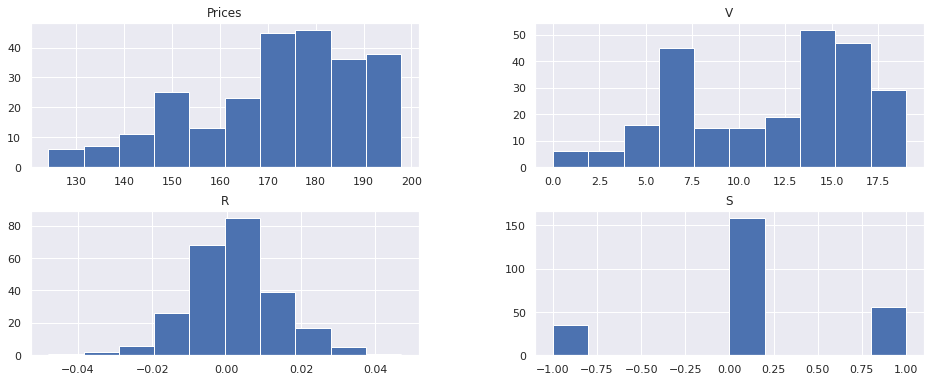

In [22]:
#VISUALIZE THE DISTRIBUTION OF METRICS OF THE DATA 
Data.hist()